In [1]:
import os
import gc

os.chdir('../../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from global_code.util import reduce_mem_usage
import matplotlib.pyplot as plt
import seaborn as sns
from global_code.util import reduce_mem_usage, clf_metric_report, compute_and_plot_permutation_importance, plot_pr_calib_curve, plot_dis_probs, plot_shap_values
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap
import json
import joblib
from venn_abers import VennAbersCalibrator

sns.set(style='whitegrid')

d:\Files\repositorios\modern-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read train, validation and calibration data

In [4]:
train_df = pd.read_parquet('./week_1/data/processed/train_df_v2.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df_v2.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df_v2.parquet')

In [5]:
cat_features = ['country', 'broad_job_category']
train_df[cat_features].dtypes

country               category
broad_job_category    category
dtype: object

### Train, Validation, Test Split

In [6]:
target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 183) (306649,)
Validation shape:  (283510, 183) (283510,)
Calibration shape:  (70878, 183) (70878,)


In [7]:
print('Train Churn Values count:\n', y_train.value_counts())
print(y_train.value_counts(normalize=True))

Train Churn Values count:
 churn_420
0    304795
1      1854
Name: count, dtype: int64
churn_420
0    0.993954
1    0.006046
Name: proportion, dtype: float64


In [8]:
print('Validation Churn Values count:\n', y_validation.value_counts())
print(y_validation.value_counts(normalize=True))

Validation Churn Values count:
 churn_420
0    279559
1      3951
Name: count, dtype: int64
churn_420
0    0.986064
1    0.013936
Name: proportion, dtype: float64


In [9]:
print('Calibration Churn Values count:\n', y_calibration.value_counts())
print(y_calibration.value_counts(normalize=True))

Calibration Churn Values count:
 churn_420
0    69890
1      988
Name: count, dtype: int64
churn_420
0    0.986061
1    0.013939
Name: proportion, dtype: float64


### Train a Vanilla Baseline CatBoost Model

In [10]:
# Using PRAUC Use Weights False to not inflat the PRAUC metric
baseline_params = {
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'PRAUC:use_weights=false',
    'cat_features': cat_features,
    'verbose': True,
    'random_seed': 55,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'learning_rate': 0.02,
    'early_stopping_rounds': 100
}
model = CatBoostClassifier(**baseline_params)

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred_baseline = model.predict_proba(X_validation)[:, 1]

Traning the model...
0:	learn: 0.0121221	test: 0.0193467	best: 0.0193467 (0)	total: 1.13s	remaining: 18m 50s
1:	learn: 0.0176100	test: 0.0252356	best: 0.0252356 (1)	total: 1.93s	remaining: 16m 2s
2:	learn: 0.0171652	test: 0.0256199	best: 0.0256199 (2)	total: 2.79s	remaining: 15m 28s
3:	learn: 0.0183683	test: 0.0264819	best: 0.0264819 (3)	total: 3.61s	remaining: 14m 58s
4:	learn: 0.0188050	test: 0.0258220	best: 0.0264819 (3)	total: 4.32s	remaining: 14m 19s
5:	learn: 0.0191801	test: 0.0264238	best: 0.0264819 (3)	total: 5.1s	remaining: 14m 4s
6:	learn: 0.0191785	test: 0.0255772	best: 0.0264819 (3)	total: 5.84s	remaining: 13m 47s
7:	learn: 0.0196897	test: 0.0268073	best: 0.0268073 (7)	total: 6.61s	remaining: 13m 39s
8:	learn: 0.0200976	test: 0.0262618	best: 0.0268073 (7)	total: 7.35s	remaining: 13m 29s
9:	learn: 0.0201351	test: 0.0262465	best: 0.0268073 (7)	total: 8.05s	remaining: 13m 16s
10:	learn: 0.0201838	test: 0.0262003	best: 0.0268073 (7)	total: 8.82s	remaining: 13m 13s
11:	learn: 0.

In [11]:
# Metrics Report
clf_metric_report(y_pred_baseline, y_validation)

Evaluating the model...
ROC AUC: 0.6875439449160486
Brier Score: 0.2730737709354388
Average Precision: 0.028297423279297983
Log Loss: 0.7281983181929271


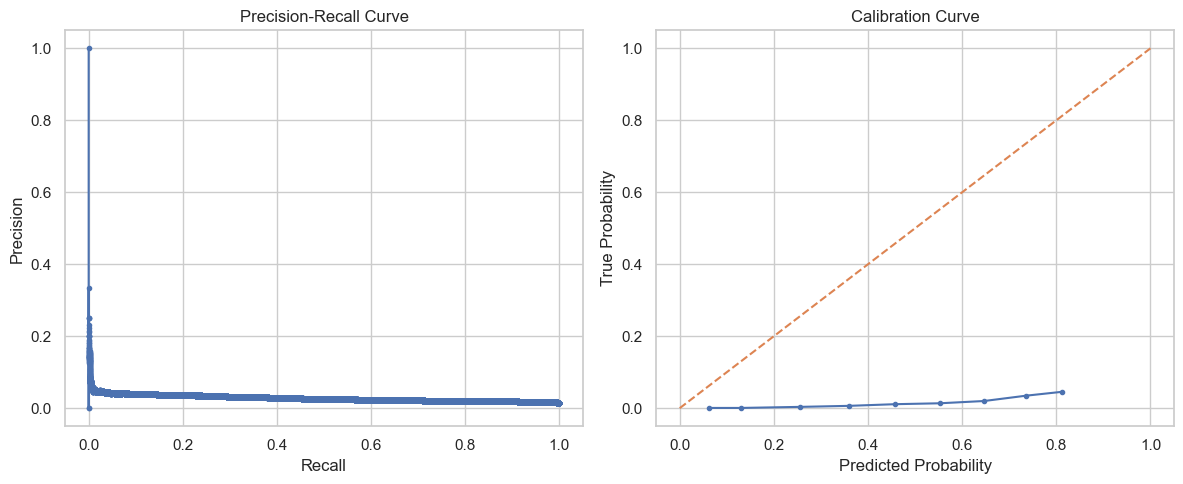

In [12]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_baseline, y_validation)

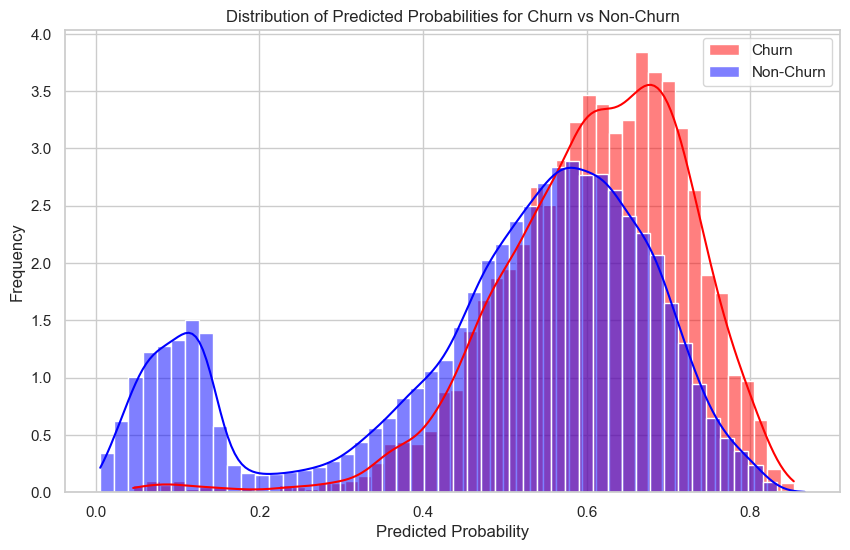

In [13]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_baseline, y_validation)

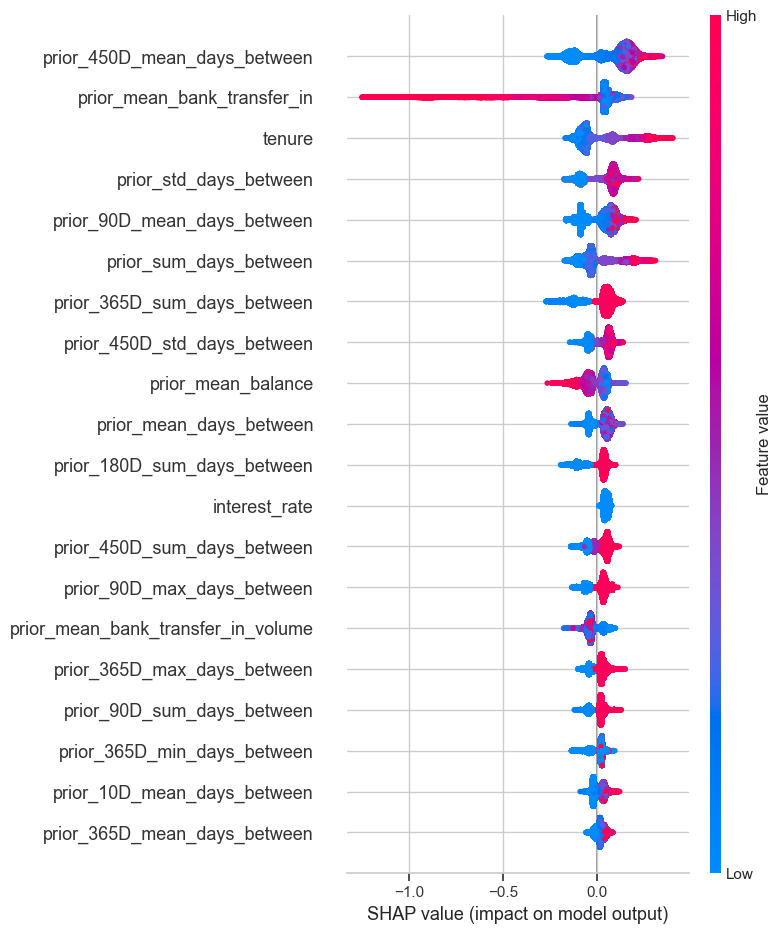

In [14]:
# SHAP Values
shap_explainer = shap.Explainer(model)
shap_values = shap_explainer(X_validation)
#shap.summary_plot(shap_values, X_validation, plot_type='dot', max_display=25)
shap.summary_plot(shap_values, X_validation)

### Feature Selection with Boruta

In [15]:
selected_features = None

In [16]:
# untuned, this is just a set of "reasonable defaults" to get better feature selection
feat_selection_params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    #'cat_features': cat_features,
    'verbose': False 
}

''''
Iteration: 	1 / 10
Confirmed: 	37
Tentative: 	47
Rejected: 	66
'''

model_for_feat_selection = CatBoostClassifier(**feat_selection_params) 

feat_selector = arfsgroot.Leshy(
    model_for_feat_selection, n_estimators=150, verbose=1, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(cat_features, axis=1), y_train)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
Leshy iteration:  90%|█████████ | 9/10 [24:20<02:42, 162.24s/it]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	28
Tentative: 	52
Rejected: 	101
All relevant predictors selected in 00:24:22.40


The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x0000027E86D11850>,
      importance='fastshap', max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x27ECAFB4E40, verbose=1)

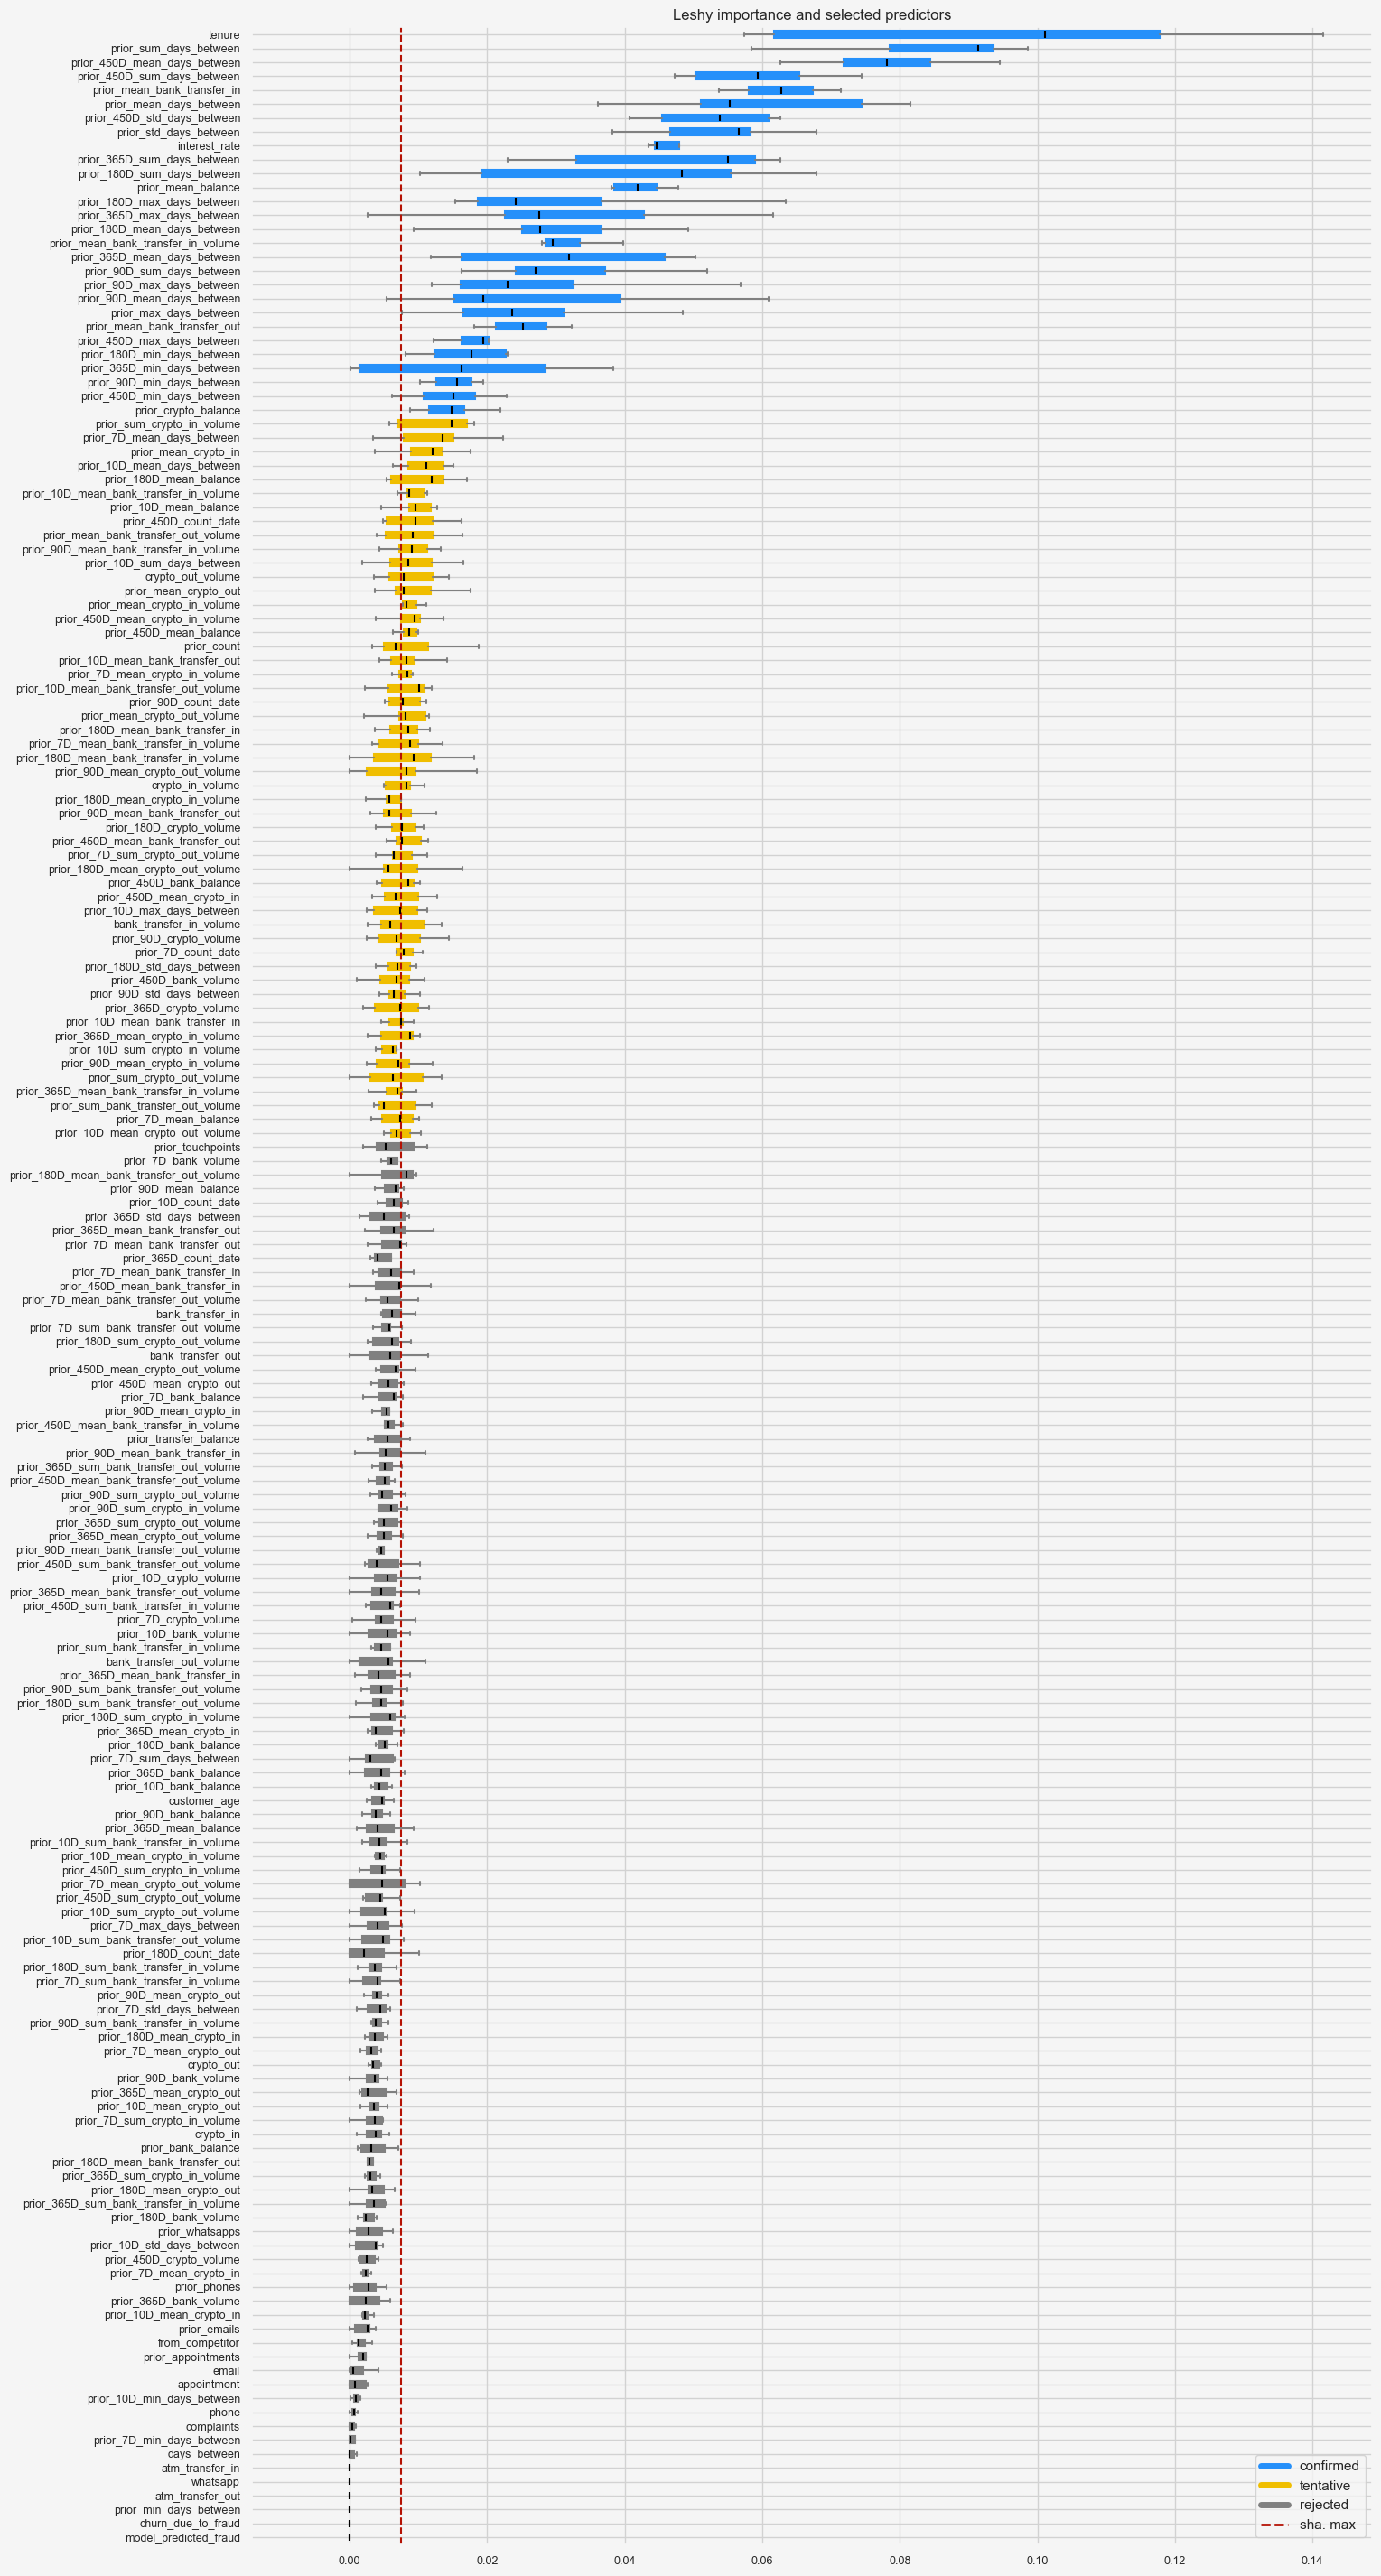

In [17]:
_ = feat_selector.plot_importance()

In [18]:
selected_features = feat_selector.get_feature_names_out().tolist() + ['country', 'broad_job_category']

# Save the selected features
with open('./week_1/model/selected_features_list.json', 'w') as f:
    json.dump(selected_features, f)

The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


In [19]:
print(f"The selected features: {selected_features}")

The selected features: ['interest_rate', 'tenure', 'prior_10D_mean_days_between', 'prior_10D_mean_bank_transfer_in_volume', 'prior_90D_sum_days_between', 'prior_90D_max_days_between', 'prior_90D_min_days_between', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_450D_sum_days_between', 'prior_450D_mean_days_between', 'prior_450D_std_days_between', 'prior_450D_max_days_between', 'prior_450D_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_bank_transfer_in_volume', 'prior_sum_crypto_in_volume', 'prior_crypto_balance', 'prior_mean_balance', 'country', 'broad_job_category']


### Train a Vanilla CatBoost Model with Selected Features

In [20]:
if selected_features == None:
    with open('./week_1/model/selected_features_list.json', 'r') as f:
        selected_features = json.load(f)

model_selected = CatBoostClassifier(**baseline_params)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=200, verbose=True)

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.0134619	test: 0.0210110	best: 0.0210110 (0)	total: 965ms	remaining: 16m 4s
1:	learn: 0.0159214	test: 0.0275541	best: 0.0275541 (1)	total: 1.55s	remaining: 12m 54s
2:	learn: 0.0170448	test: 0.0275923	best: 0.0275923 (2)	total: 2.4s	remaining: 13m 17s
3:	learn: 0.0176387	test: 0.0285958	best: 0.0285958 (3)	total: 3.33s	remaining: 13m 49s
4:	learn: 0.0189713	test: 0.0286637	best: 0.0286637 (4)	total: 4.12s	remaining: 13m 40s
5:	learn: 0.0193477	test: 0.0282273	best: 0.0286637 (4)	total: 4.73s	remaining: 13m 4s
6:	learn: 0.0186119	test: 0.0281516	best: 0.0286637 (4)	total: 5.46s	remaining: 12m 54s
7:	learn: 0.0192122	test: 0.0287452	best: 0.0287452 (7)	total: 6.13s	remaining: 12m 39s
8:	learn: 0.0192279	test: 0.0290932	best: 0.0290932 (8)	total: 6.8s	remaining: 12m 28s
9:	learn: 0.0194575	test: 0.0293541	best: 0.0293541 (9)	total: 7.35s	remaining: 12m 7s
10:	learn: 0.0199851	test: 0.0294814	best: 0.0294814 (10)	total: 7.96s	remaining: 11m 55s
11:	learn: 0.0200301	test: 0.029653

In [21]:
# Model metrics report
clf_metric_report(y_pred_selected, y_validation)

Evaluating the model...
ROC AUC: 0.7010793500287231
Brier Score: 0.2791466657487489
Average Precision: 0.031039970123762507
Log Loss: 0.7437834184928249


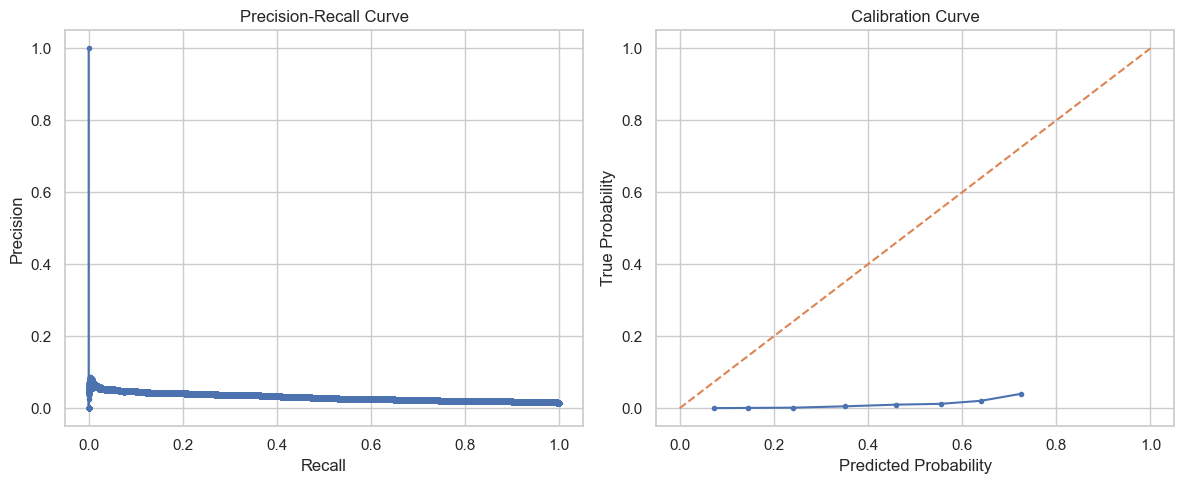

In [22]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

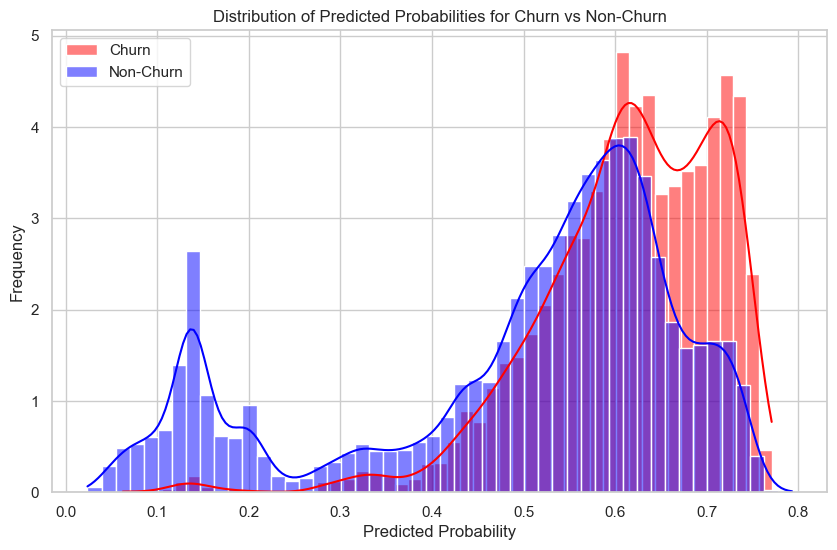

In [23]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)

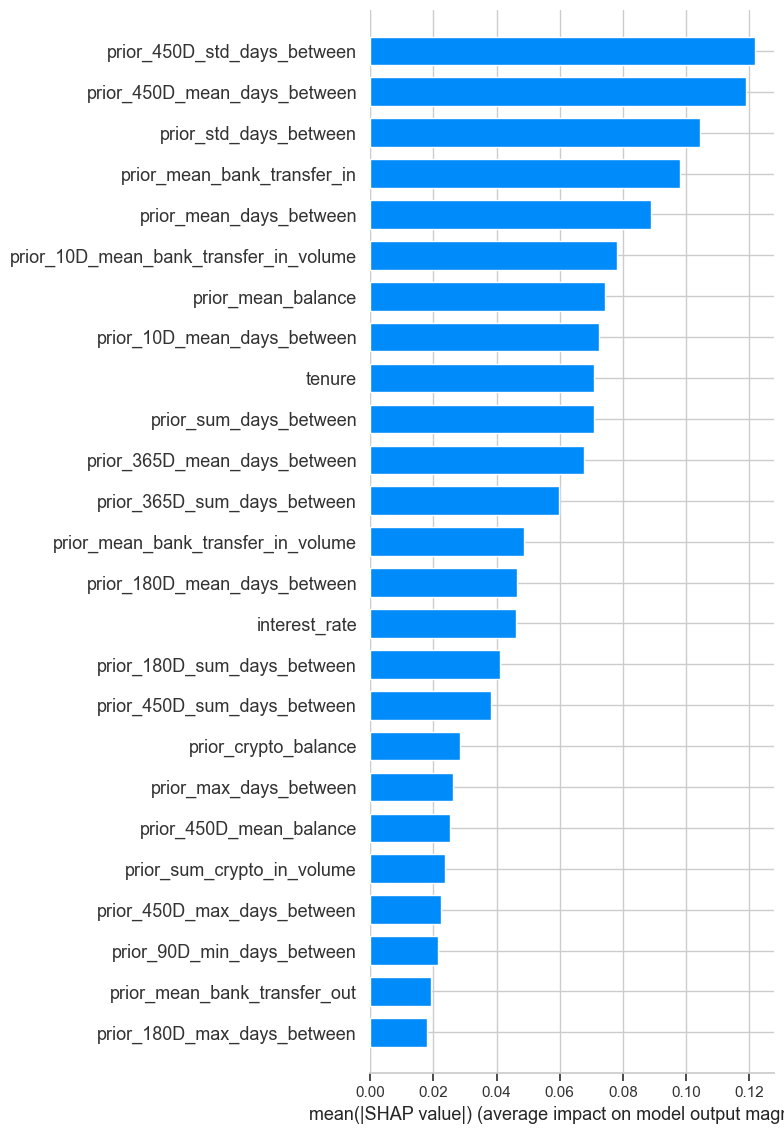

In [24]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

### Comparing Baseline and the Feature Selected model

In [25]:
print('Baseline model')
clf_metric_report(y_pred_baseline, y_validation)
print('')

print('Feature selection model')
clf_metric_report(y_pred_selected, y_validation)
print('')

Baseline model
Evaluating the model...
ROC AUC: 0.6875439449160486
Brier Score: 0.2730737709354388
Average Precision: 0.028297423279297983
Log Loss: 0.7281983181929271

Feature selection model
Evaluating the model...
ROC AUC: 0.7010793500287231
Brier Score: 0.2791466657487489
Average Precision: 0.031039970123762507
Log Loss: 0.7437834184928249



In [26]:
print('Average precision improvement: ', (average_precision_score(y_validation, y_pred_selected) - average_precision_score(y_validation, y_pred_baseline)) / average_precision_score(y_validation, y_pred_baseline))

Average precision improvement:  0.09691860694860281


### Saving the model and artifacts

In [27]:
# Save the baseline model
baseline_model_path = './week_1/model/baseline_model.joblib'
joblib.dump(model, baseline_model_path)

# Save the model trained with selected features
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'
joblib.dump(model_selected, feat_selection_model_path)

print(f"Baseline model saved to: {baseline_model_path}")
print(f"Baseline model saved to: {feat_selection_model_path}")

Baseline model saved to: ./week_1/model/baseline_model.joblib
Baseline model saved to: ./week_1/model/feat_selection_model.joblib
